Amazon Fine Food Reviews Dataset is used. Also, two models are employed -

1. First one uses Trained Glove Embeddings to average out embeddings for the corresponding words in the whole review and then applies training on the dataset.
2. Second one also uses Trained Glove Embedding Layer but does not perform averaging and uses a more complex model.



In [25]:
import os
import random
import pandas as pd

import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import functools
from keras import backend as K
    
import tensorflow as tf
from tensorflow.python.keras.preprocessing.sequence import pad_sequences 
from tensorflow.python.keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, GRU, Activation, Bidirectional
from keras.optimizers import Adam
from keras.initializers import Constant

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
path = "amazon_reviews_cleaned.csv"

data = pd.read_csv(path, encoding="utf-8")

print("Shape of data: ", data.shape)
data.head()

Shape of data:  (10000, 10)


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Score,Review
0,507211,507212.0,B00127T7TK,A2BQ9N8O1QA00N,C. D. Rickert,2.0,3.0,1.294618e+09,0.0,ok syrup thick mean mix shave ice rather pour ...
1,495822,495823.0,B000PJAQR8,A27DUQTEV26CXG,saywut,1.0,1.0,1.279152e+09,1.0,addictive apparently addictive property ive me...
2,242795,242796.0,B000BF3AII,A24R1AOSCZ4CO7,steveeb,0.0,0.0,1.275178e+09,1.0,try tortilla soup rice . family love dice chik...
3,120352,120353.0,B005K4Q37A,AWEBTQUXK7YB4,Steven Pretzman,2.0,3.0,1.344211e+09,0.0,sweet poor taste . sweet make sick . stuff awf...
4,128467,128468.0,B007L3NVKU,A3S84XXELJ0YX2,R. A. Balkam,0.0,0.0,1.322698e+09,1.0,delish love coffee . like strong coffee right ...


In [3]:
# reviews_text = data["Text"].values
# reviews_title = data["Summary"].values
reviews = data["Review"].values
reviews_rating = data["Score"].values

In [4]:
reviews_rating

array([0., 1., 1., ..., 1., 1., 0.])

In [5]:
# nltk libraries

stop_words = set(stopwords.words('english'))
lemmatiser = WordNetLemmatizer()

In [6]:
# returns the Part-Of-Speech(pos) tag which is required as an argument for
# lemmatizer for determiing the context of the word for lemmatization

def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):  
        return 'a' # adjective
    elif pos_tag.startswith('V'): 
        return 'v' # verb
    elif pos_tag.startswith('R'):
        return 'r' # adverb
    else:           
        return 'n' # fallback to noun

In [7]:
# performs all sorts of preprocessing on text

def preprocess_text(text):
    
    # lowercase the entire text
    text = text.lower()
    
    # remove all html tags from dataset
    text = re.sub(r'<.*?>',"",text)
    
    # Replace special characters and punctuation by a 
    # blank ( except for full stop(.))
    text = re.sub('[^a-z0-9 \.]', '', text)
    
    # split the text into words
    words = word_tokenize(text) 
    
    # remove stop words like to, an, the, of, over, his, her, there, their ...
    words = [w for w in words if w =="not" or not w in stop_words ]
    
    # get pos tagging for words, required by lemmatizer
    words_pos = pos_tag(words) 
    
    lemmatized_words = []
    
    for word, tag in words_pos:
        pos = get_wordnet_pos(tag)
        lemmatized_word = lemmatiser.lemmatize(word, pos=pos)
        lemmatized_words.append(lemmatized_word)
    
    text = " ".join(lemmatized_words)
    
    
    return text

In [8]:
DATA_SIZE = reviews.size

# reviews = []
labels = np.zeros(DATA_SIZE)

In [9]:
# data preprocessing step
# will take several minutes!(almost an hour)

for i in range(DATA_SIZE):
    
#     text = str(reviews_text[i])
#     title = str(reviews_title[i])
    rating = reviews_rating[i]
    
#     review = title + " " + text
#     review = preprocess_text(review)
#     reviews.append(review)
    if(rating == 1.0):
        labels[i] = 1 # Positive Review (1)

In [10]:
labels

array([0., 1., 1., ..., 1., 1., 0.])

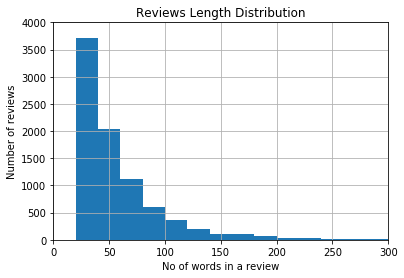

In [11]:
# plot showing lengthwise distribution of reviews

bins = [20*i for i in range(1, 30)]

plt.hist([len(s.split()) for s in reviews], bins=bins)

plt.xlabel('No of words in a review')
plt.ylabel('Number of reviews')
plt.title('Reviews Length Distribution') 

plt.axis([0, 300, 0, 4000])
plt.grid(True)

plt.show()

The majority of reviews are covered if length < 70 words

In [12]:
review_texts = []
review_labels = []

THRESHOLD_WORDS =70

In [13]:
# considering only those reviews whose length <= (THRESHOLD_WORDS = 60)


for idx, review in enumerate(reviews):
    
    if(len(review.split()) <= THRESHOLD_WORDS):
        review_texts.append(review)
        review_labels.append(labels[idx])
        

In [14]:
review_labels = np.array(review_labels)

In [15]:
NEW_DATA_SIZE = review_labels.shape[0]

In [16]:
# TRAIN - VALIDATION - TEST SPLIT

TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TRAIN_INDEX = int(TRAIN_RATIO*NEW_DATA_SIZE)
VAL_INDEX = TRAIN_INDEX + int(VAL_RATIO*NEW_DATA_SIZE)

train_texts = review_texts[:TRAIN_INDEX]
y_train = review_labels[:TRAIN_INDEX]

val_texts = review_texts[TRAIN_INDEX:VAL_INDEX]
y_val = review_labels[TRAIN_INDEX:VAL_INDEX]

test_texts = review_texts[VAL_INDEX:]
y_test = review_labels[VAL_INDEX:]


<BarContainer object of 50 artists>

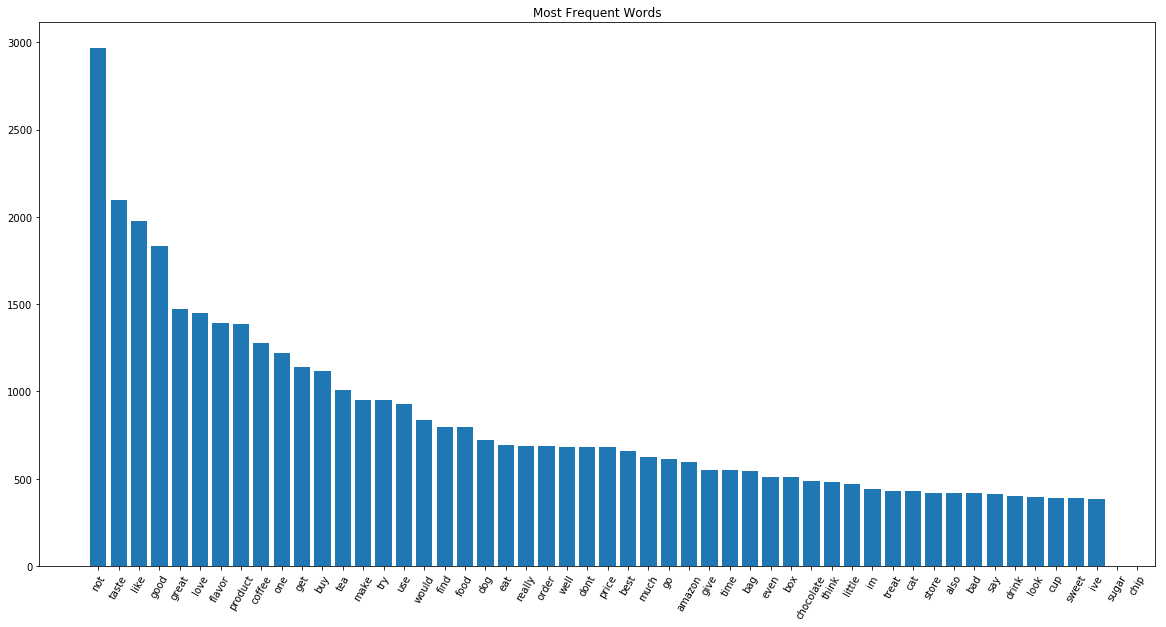

In [17]:
# tokenizing the reviews words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

MOST_K_FREQUENT = 100
TOP_K_FREQUENT = 50

def get_key(word_freq_pair):
    word, freq = word_freq_pair
    return freq
    
# MOST_K_FREQUENT WORDS
frequent_words = sorted(list(tokenizer.word_counts.items()), key = get_key, reverse = True)[:MOST_K_FREQUENT]

x = [i for i in range(MOST_K_FREQUENT)]
x_words = []
y_word_freq = []

for word, count in frequent_words:
    x_words.append(word)
    y_word_freq.append(count)

# plot showing most occuring words in the dataset    

mpl.rcParams['figure.figsize'] = (20,10)

plt.xticks(x, x_words)
plt.xticks(rotation=60)

plt.title("Most Frequent Words")

plt.bar(x[:TOP_K_FREQUENT], y_word_freq[:TOP_K_FREQUENT])

In [18]:
# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = THRESHOLD_WORDS

# Create vocabulary with training texts.
# By default, all punctuation is removed
tokenizer = Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(train_texts)

# Vectorize training and validation texts.
x_train = tokenizer.texts_to_sequences(train_texts)
x_val = tokenizer.texts_to_sequences(val_texts)
x_test = tokenizer.texts_to_sequences(test_texts)

# Fix sequence length to MAX_SEQUENCE_LENGTH. Sequences shorter than the length are
# padded and sequences longer are truncated
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    

In [19]:

# creating dictionary of words containing corresponding word embeddings

filename = "glove.6B.100d.txt"

embeddings_index = {}

f = open(filename,  encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
    
f.close()


In [20]:

# dimension of each word embedding
EMBEDDING_DIM = 100

# creating embedding matrix for directly feeding to Embedding() layer of Keras

num_words = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    
    if i > num_words:
        continue
        
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

## CNN

In [45]:

model_pretrained_glove = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_pretrained_glove.add(embedding_layer)
model_pretrained_glove.add(Dropout(0.3))

model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
model_pretrained_glove.add(MaxPooling1D(pool_size=4))

model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
model_pretrained_glove.add(Flatten())
model_pretrained_glove.add(Dropout(0.4))

model_pretrained_glove.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_pretrained_glove.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_pretrained_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 70, 100)           1135900   
_________________________________________________________________
dropout_14 (Dropout)         (None, 70, 100)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 66, 64)            32064     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 12, 64)            20544     
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 768)               0         
__________

In [46]:

# training the model
model_pretrained_glove_history = model_pretrained_glove.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val))


Train on 4779 samples, validate on 1593 samples
Epoch 1/15
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6771 - acc: 0.5798 - val_loss: 0.6011 - val_acc: 0.6937
Epoch 2/15
4779/4779 [==============================] - 3s 597us/step - loss: 0.5538 - acc: 0.7219 - val_loss: 0.5015 - val_acc: 0.7847
Epoch 3/15
4779/4779 [==============================] - 3s 603us/step - loss: 0.4750 - acc: 0.7780 - val_loss: 0.4398 - val_acc: 0.8060
Epoch 4/15
4779/4779 [==============================] - 3s 610us/step - loss: 0.4179 - acc: 0.8152 - val_loss: 0.4122 - val_acc: 0.8205
Epoch 5/15
4779/4779 [==============================] - 3s 616us/step - loss: 0.3712 - acc: 0.8408 - val_loss: 0.3980 - val_acc: 0.8311
Epoch 6/15
4779/4779 [==============================] - 4s 809us/step - loss: 0.3352 - acc: 0.8588 - val_loss: 0.4595 - val_acc: 0.7935
Epoch 7/15
4779/4779 [==============================] - 5s 997us/step - loss: 0.3101 - acc: 0.8667 - val_loss: 0.3875 - val_acc: 0.8431
Ep

In [29]:
# model history parameters

history = model_pretrained_glove_history.history

train_accuracy = history['acc']
train_loss = history['loss']

val_accuracy = history['val_acc']
val_loss = history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

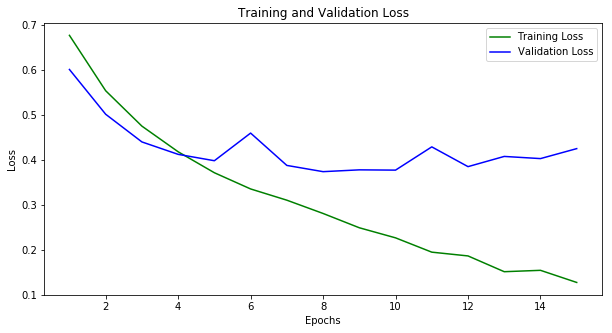

In [48]:
# plot showing training and validation losses

mpl.rcParams['figure.figsize'] = (10, 5)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

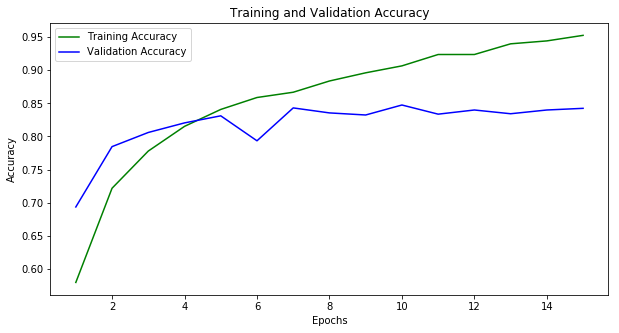

In [49]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [50]:
# evaluating the model on test dataset
model_pretrained_glove.evaluate(x_test, y_test)

1594/1594 [==============================] - 0s 124us/step


[0.40426084844201543, 0.842534504092323]

In [51]:
# custom test samples

samples = [
           "The taste of the biscuits was quite spectacular. It seemed as if it was taken straight from heaven",
           "Peanuts were too salty according to my taste",
            "If you are looking for a secret ingredient, go for it",
            "I am disappointed with the rice",
            "I am not disappointed with the rice",
            "Loved the food and the place." ,
            "Vibe check."
          ]

processed_samples = []
for sample in samples:
    processed_samples.append(preprocess_text(sample))

vectorized_samples = tokenizer.texts_to_sequences(processed_samples)
vectorized_samples = pad_sequences(vectorized_samples, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

predictions = model_pretrained_glove.predict(vectorized_samples)

THRESHOLD_PREDICTION = 0.6

for idx, pred in enumerate(predictions):
    if(pred > THRESHOLD_PREDICTION):
        print("{}.".format(idx+1),samples[idx], " || +ve with {:.2f}% surity".format(pred[0]*100))
    else:
        print("{}.".format(idx+1),samples[idx], " || -ve with {:.2f}% surity".format(100-pred[0]*100))


1. The taste of the biscuits was quite spectacular. It seemed as if it was taken straight from heaven  || +ve with 95.62% surity
2. Peanuts were too salty according to my taste  || -ve with 95.80% surity
3. If you are looking for a secret ingredient, go for it  || -ve with 65.41% surity
4. I am disappointed with the rice  || -ve with 92.91% surity
5. I am not disappointed with the rice  || -ve with 97.81% surity
6. Loved the food and the place.  || +ve with 79.79% surity
7. Vibe check.  || -ve with 56.32% surity


In [29]:
# saving the pre-trained glove model
# model_pretrained_glove.save("pretrained_glove_model.h5")

# LSTM

In [53]:
model_pretrained_glove = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_pretrained_glove.add(embedding_layer)
model_pretrained_glove.add(Dropout(0.3))

model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
model_pretrained_glove.add(MaxPooling1D(pool_size=4))

model_pretrained_glove.add(LSTM(64,activation='relu',return_sequences=True))
model_pretrained_glove.add(Dropout(0.4))

model_pretrained_glove.add(LSTM(128,activation='tanh'))
model_pretrained_glove.add(Dropout(0.4))

# model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
# model_pretrained_glove.add(MaxPooling1D(pool_size=4))

model_pretrained_glove.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_pretrained_glove.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_pretrained_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 70, 100)           1135900   
_________________________________________________________________
dropout_16 (Dropout)         (None, 70, 100)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 66, 64)            32064     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 16, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16, 64)            33024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               98816     
__________

In [54]:

# training the model
model_pretrained_glove_history = model_pretrained_glove.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val))


Train on 4779 samples, validate on 1593 samples
Epoch 1/15
4779/4779 [==============================] - 14s 3ms/step - loss: 0.6406 - acc: 0.6208 - val_loss: 0.5372 - val_acc: 0.7784
Epoch 2/15
4779/4779 [==============================] - 11s 2ms/step - loss: 0.4942 - acc: 0.7705 - val_loss: 0.4524 - val_acc: 0.7897
Epoch 3/15
4779/4779 [==============================] - 11s 2ms/step - loss: 0.4362 - acc: 0.7979 - val_loss: 0.4066 - val_acc: 0.8330
Epoch 4/15
4779/4779 [==============================] - 11s 2ms/step - loss: 0.3869 - acc: 0.8293 - val_loss: 0.4236 - val_acc: 0.8117
Epoch 5/15
4779/4779 [==============================] - 11s 2ms/step - loss: 0.3698 - acc: 0.8385 - val_loss: 0.3671 - val_acc: 0.8418
Epoch 6/15
4779/4779 [==============================] - 10s 2ms/step - loss: 0.3202 - acc: 0.8675 - val_loss: 0.4130 - val_acc: 0.8336
Epoch 7/15
4779/4779 [==============================] - 10s 2ms/step - loss: 0.2954 - acc: 0.8809 - val_loss: 0.3829 - val_acc: 0.8380
Epoch 8

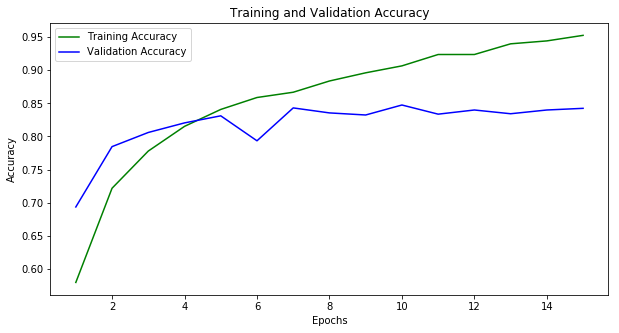

In [58]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [59]:
# evaluating the model on test dataset
model_pretrained_glove.evaluate(x_test, y_test)

1594/1594 [==============================] - 1s 363us/step


[0.43657450196584463, 0.8381430360125179]

In [67]:
# custom test samples

samples = [
           "The taste was very bad",
           "Peanuts were too salty according to my taste",
            "Food at its best",
            "I am disappointed with the rice",
            "I am not disappointed with the rice",
            "Loved the food and the place." ,
            "Visually beautiful but bad taste"
          ]

processed_samples = []
for sample in samples:
    processed_samples.append(preprocess_text(sample))

vectorized_samples = tokenizer.texts_to_sequences(processed_samples)
vectorized_samples = pad_sequences(vectorized_samples, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

predictions = model_pretrained_glove.predict(vectorized_samples)

THRESHOLD_PREDICTION = 0.6

for idx, pred in enumerate(predictions):
    if(pred > THRESHOLD_PREDICTION):
        print("{}.".format(idx+1),samples[idx], " || positive with {:.2f}% ".format(pred[0]*100))
    else:
        print("{}.".format(idx+1),samples[idx], " || negative with {:.2f}% ".format(100-pred[0]*100))


1. The taste was very bad  || negative with 98.19% 
2. Peanuts were too salty according to my taste  || negative with 91.00% 
3. Food at its best  || positive with 99.99% 
4. I am disappointed with the rice  || negative with 83.92% 
5. I am not disappointed with the rice  || negative with 91.13% 
6. Loved the food and the place.  || positive with 88.47% 
7. Visually beautiful but bad taste  || negative with 51.59% 


# GRU

In [21]:
model_pretrained_glove = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_pretrained_glove.add(embedding_layer)
model_pretrained_glove.add(Dropout(0.3))

model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
model_pretrained_glove.add(MaxPooling1D(pool_size=4))

model_pretrained_glove.add(GRU(64,activation='relu',return_sequences=True))
model_pretrained_glove.add(Dropout(0.4))

model_pretrained_glove.add(GRU(128,activation='tanh'))
model_pretrained_glove.add(Dropout(0.4))

# model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
# model_pretrained_glove.add(MaxPooling1D(pool_size=4))

model_pretrained_glove.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_pretrained_glove.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_pretrained_glove.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 100)           1135900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 66, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16, 64)            24768     
_________________________________________________________________
dropout_2 (Dropout)  

In [24]:

# training the model
model_pretrained_glove_history = model_pretrained_glove.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val))


Train on 4779 samples, validate on 1593 samples
Epoch 1/15
4779/4779 [==============================] - 12s 3ms/step - loss: 0.3057 - acc: 0.8719 - val_loss: 0.3917 - val_acc: 0.8437
Epoch 2/15
4779/4779 [==============================] - 11s 2ms/step - loss: 0.2721 - acc: 0.8881 - val_loss: 0.3840 - val_acc: 0.8600
Epoch 3/15
4779/4779 [==============================] - 11s 2ms/step - loss: 0.2432 - acc: 0.9008 - val_loss: 0.3651 - val_acc: 0.8525
Epoch 4/15
4779/4779 [==============================] - 10s 2ms/step - loss: 0.2010 - acc: 0.9190 - val_loss: 0.4307 - val_acc: 0.8462
Epoch 5/15
4779/4779 [==============================] - 11s 2ms/step - loss: 0.1976 - acc: 0.9213 - val_loss: 0.3805 - val_acc: 0.8506
Epoch 6/15
4779/4779 [==============================] - 12s 2ms/step - loss: 0.1826 - acc: 0.9261 - val_loss: 0.4549 - val_acc: 0.8293
Epoch 7/15
4779/4779 [==============================] - 12s 2ms/step - loss: 0.1800 - acc: 0.9303 - val_loss: 0.4494 - val_acc: 0.8550
Epoch 8

In [26]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

NameError: name 'epochs' is not defined

In [31]:
# evaluating the model on test dataset
model_pretrained_glove.evaluate(x_test, y_test)

1594/1594 [==============================] - 1s 886us/step


[0.3669122848636383, 0.8601003765611158]

# Bidirectional

In [27]:
model_pretrained_glove = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_pretrained_glove.add(embedding_layer)
model_pretrained_glove.add(Dropout(0.3))

model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
model_pretrained_glove.add(MaxPooling1D(pool_size=4))

model_pretrained_glove.add(Bidirectional(LSTM(64,activation='relu',return_sequences=True)))
model_pretrained_glove.add(Dropout(0.4))

model_pretrained_glove.add(Bidirectional(LSTM(128,activation='tanh')))
model_pretrained_glove.add(Dropout(0.4))

# model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
# model_pretrained_glove.add(MaxPooling1D(pool_size=4))

model_pretrained_glove.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_pretrained_glove.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_pretrained_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 100)           1135900   
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 66, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 128)           66048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
__________

In [28]:

# training the model
model_pretrained_glove_history = model_pretrained_glove.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val))


Train on 4779 samples, validate on 1593 samples
Epoch 1/15
4779/4779 [==============================] - 33s 7ms/step - loss: 0.6140 - acc: 0.6616 - val_loss: 0.5020 - val_acc: 0.7677
Epoch 2/15
4779/4779 [==============================] - 18s 4ms/step - loss: 0.5048 - acc: 0.7612 - val_loss: 0.4377 - val_acc: 0.8023
Epoch 3/15
4779/4779 [==============================] - 18s 4ms/step - loss: 0.4368 - acc: 0.8021 - val_loss: 0.4517 - val_acc: 0.7922
Epoch 4/15
4779/4779 [==============================] - 17s 4ms/step - loss: 0.3836 - acc: 0.8305 - val_loss: 0.4744 - val_acc: 0.7734
Epoch 5/15
4779/4779 [==============================] - 18s 4ms/step - loss: 0.3675 - acc: 0.8412 - val_loss: 0.3713 - val_acc: 0.8456
Epoch 6/15
4779/4779 [==============================] - 18s 4ms/step - loss: 0.3191 - acc: 0.8690 - val_loss: 0.3536 - val_acc: 0.8650
Epoch 7/15
4779/4779 [==============================] - 18s 4ms/step - loss: 0.2961 - acc: 0.8782 - val_loss: 0.3570 - val_acc: 0.8600
Epoch 8

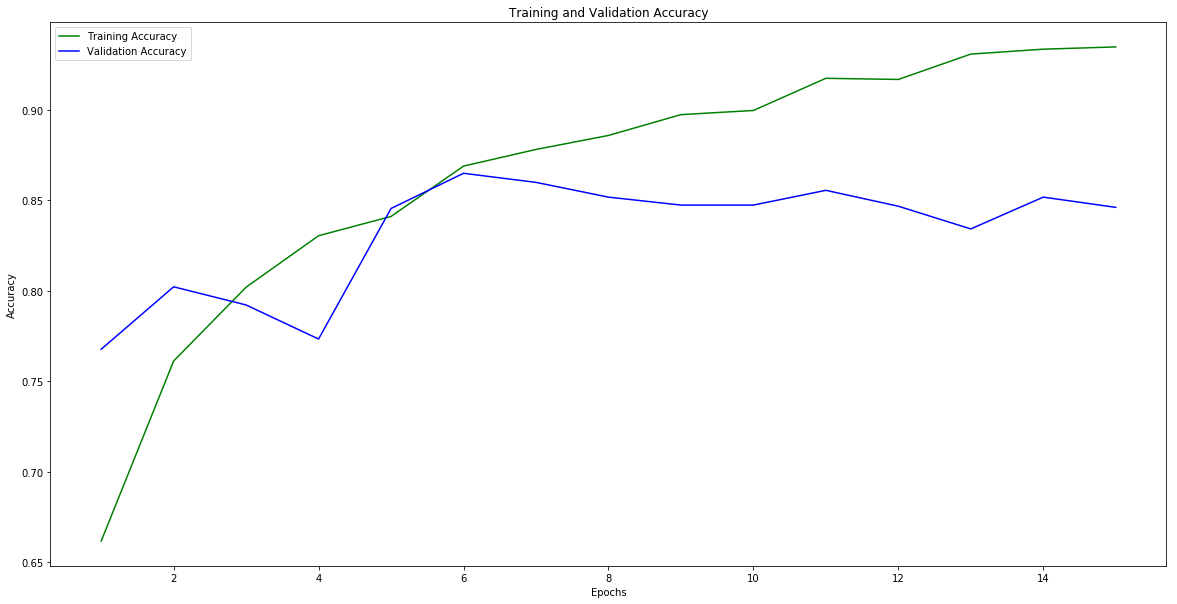

In [30]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [32]:
# evaluating the model on test dataset
model_pretrained_glove.evaluate(x_test, y_test)

1594/1594 [==============================] - 1s 861us/step


[0.3669122848636383, 0.8601003765611158]